In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

%matplotlib inline

In [21]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train,y_train), (x_test,y_test) = fashion_mnist.load_data()

x_train, x_test = x_train/255.0 *2 - 1, x_test/255.0 *2 - 1
print (x_train.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)


In [0]:
 N,H,W = x_train.shape
 D = H * W
 x_train = x_train.reshape(-1, D)
 x_test = x_test.reshape(-1, D)

In [0]:
latent_dim = 100

In [0]:
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256,activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512,activation=LeakyReLU(alpha=0.8))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024,activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D,activation='tanh')(x)

  model = Model(i,x)
  return model

In [0]:
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512,activation=LeakyReLU(0.2))(i)
  x = Dense(256,activation=LeakyReLU(0.2))(x)
  x = Dense(1,activation='sigmoid')(x)
  
  model = Model(i,x)
  return model

In [0]:
discriminator = build_discriminator(D)
discriminator.compile(
    loss="binary_crossentropy",
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

generator = build_generator(latent_dim)

z = Input(shape=(latent_dim,))
img = generator(z)

discriminator.trainable = False

fake_pred = discriminator(img)

combined_model = Model(z,fake_pred)

combined_model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(0.0002,0.5)
)


batch_size = 32
epochs = 30000
sample_period = 250


ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

g_losses = []
d_losses = []

if not os.path.exists('gen_images'):
  os.makedirs("gen_images")


In [0]:
def sample_images(epoch):
  rows,cols = 5,5
  noise = np.random.randn(rows*cols,latent_dim)
  imgs = generator.predict(noise)

  imgs = 0.5 * imgs + 0.5
  fig,axs = plt.subplots(rows,cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W),cmap='gray')
      axs[i,j].axis('off')
      idx+= 1
  fig.savefig("gen_images/%d.png" % epoch)
  plt.close()

In [28]:
for epoch in range(epochs):
  ##################################
  ##### Training discriminator #####
  ##################################

  # SELECT A RANDOM BATCH OF IMAGES
  idx = np.random.randint(0,x_train.shape[0],batch_size)
  real_imgs = x_train[idx]

  # GENERATE FAKE IMAGES
  noise = np.random.randn(batch_size,latent_dim)
  fake_imgs = generator.predict(noise)

  # Train the discriminator
  d_loss_real , d_acc_real = discriminator.train_on_batch(real_imgs,ones)
  d_loss_fake , d_acc_fake = discriminator.train_on_batch(fake_imgs,zeros)

  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)


  #################################
  ##### Training Generator ########
  #################################

  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise,ones)

  # Save losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print (f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

  if epoch % sample_period == 0:
    sample_images(epoch)

epoch: 1/30000, d_loss: 0.75, d_acc: 0.55, g_loss: 0.90
epoch: 101/30000, d_loss: 0.01, d_acc: 1.00, g_loss: 4.50
epoch: 201/30000, d_loss: 0.06, d_acc: 1.00, g_loss: 4.34
epoch: 301/30000, d_loss: 0.60, d_acc: 0.66, g_loss: 2.81
epoch: 401/30000, d_loss: 0.55, d_acc: 0.75, g_loss: 1.43
epoch: 501/30000, d_loss: 0.69, d_acc: 0.59, g_loss: 1.00
epoch: 601/30000, d_loss: 0.54, d_acc: 0.73, g_loss: 0.99
epoch: 701/30000, d_loss: 0.63, d_acc: 0.66, g_loss: 1.01
epoch: 801/30000, d_loss: 0.53, d_acc: 0.75, g_loss: 1.00
epoch: 901/30000, d_loss: 0.63, d_acc: 0.67, g_loss: 0.96
epoch: 1001/30000, d_loss: 0.50, d_acc: 0.73, g_loss: 0.98
epoch: 1101/30000, d_loss: 0.56, d_acc: 0.67, g_loss: 0.96
epoch: 1201/30000, d_loss: 0.49, d_acc: 0.83, g_loss: 1.02
epoch: 1301/30000, d_loss: 0.58, d_acc: 0.70, g_loss: 0.97
epoch: 1401/30000, d_loss: 0.64, d_acc: 0.58, g_loss: 0.93
epoch: 1501/30000, d_loss: 0.56, d_acc: 0.69, g_loss: 0.98
epoch: 1601/30000, d_loss: 0.64, d_acc: 0.59, g_loss: 1.04
epoch: 17

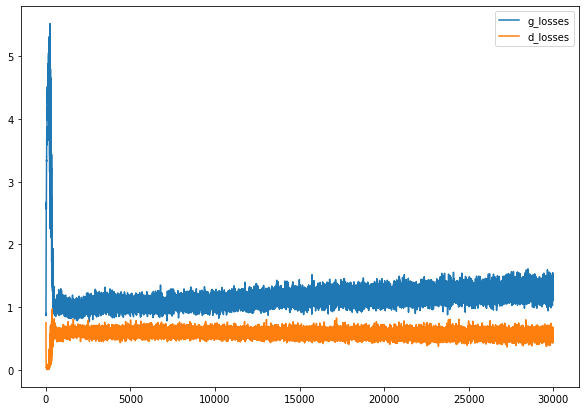

In [29]:
plt.figure(figsize=(10,7))
plt.plot(g_losses,label='g_losses')
plt.plot(d_losses,label='d_losses')
plt.legend()
plt.show()

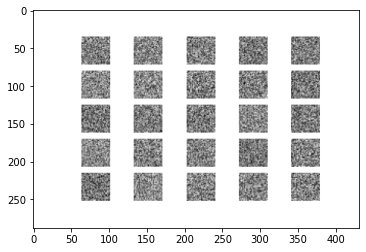

In [30]:
from skimage.io import imread
a = imread('gen_images/0.png')
plt.imshow(a)
plt.show()

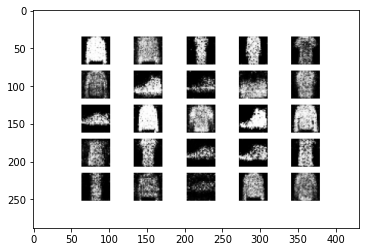

In [31]:
a = imread('gen_images/5000.png')
plt.imshow(a)
plt.show()

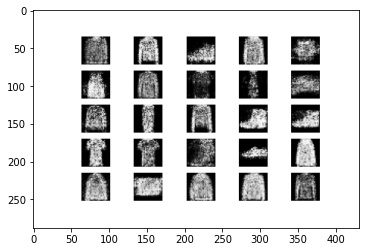

In [32]:
a = imread('gen_images/10000.png')
plt.imshow(a)
plt.show()

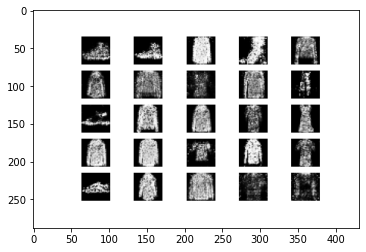

In [33]:
a = imread('gen_images/20000.png')
plt.imshow(a)
plt.show()

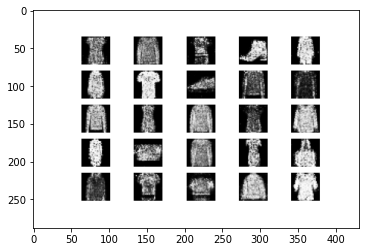

In [36]:
a = imread('gen_images/29750.png')
plt.imshow(a)
plt.show()